# Logistic Regression Modeling and Metrics With TF-IDF Vectorier
---

## Contents
---
- [Library and Data Imports](#Library-and-Data-Imports)
- [Train Test Split and Base Model](#Train-Test-Split-and-Base-Model)
- [Logistic Regression with TfidfVectorizer](#Logistic-Regression-with-TfidfVectorizer)
- [Predictions and Interpretation](#Predictions-and-Interpretation)
- [Confusion Matrix Interpretation](#Confusion-Matrix-Interpretation)

## Library and Data Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler


**Read in text_processed_corpus.csv**

In [2]:
text_processed_corpus = pd.read_csv('./data/text_processed_corpus.csv')

## Train Test Split and Base Model
___

In [3]:
#Train Test Split
X = text_processed_corpus['processed_text']
y = text_processed_corpus['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    stratify = y,
                                                    random_state = 24)
                                                    
    

**What is the base model?**
* There is a **56%** chance of correctly predicting a post belongs in the fountainpens reddit.

In [4]:
y.value_counts(normalize = True) * 100

subreddit
1    55.615165
0    44.384835
Name: proportion, dtype: float64

In [5]:
#Ensuring that stratify is maintaining the slight skew between the two subreddit
y_train.value_counts(normalize = True), y_test.value_counts(normalize = True)

(subreddit
 1    0.556032
 0    0.443968
 Name: proportion, dtype: float64,
 subreddit
 1    0.556509
 0    0.443491
 Name: proportion, dtype: float64)

In [6]:
# Summon the vectorizers and estimators
tvec = TfidfVectorizer()
logreg = LogisticRegression()

## Logistic Regression with TfidfVectorizer
___

In [7]:
# Build a pipeline
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logreg', LogisticRegression())
])

In [8]:
# Checking an initial score without actually fitting anything. 
cross_val_score(pipe, X_train, y_train, cv=3).mean()

0.8636146876490224

In [9]:
# Create parameters for a gridsearch over to see what performs best -  Started with2100 total models not including cv.
# Varied parameters until ideal parameters were determined.
# I did not include a stop_words parameter becuse this was already done with SpaCy
pipe_params = {
    'tvec__max_features': [200, 300, 400],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'tvec__max_df': [0.6, 0.7,0.8],
    'tvec__min_df': [0.00001, 0.0001, 0.001],
    'logreg__C': [1.0,0.1, 0.01],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver': ['liblinear']
}
    

In [10]:
#GridSearch set-up
gs = GridSearchCV(pipe,
                  pipe_params,
                  cv = 5)

In [11]:
#GridSearch the training data.

gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'logreg__C': [1.0, 0.1, 0.01],
                         'logreg__penalty': ['l1', 'l2'],
                         'logreg__solver': ['liblinear'],
                         'tvec__max_df': [0.6, 0.7, 0.8],
                         'tvec__max_features': [200, 300, 400],
                         'tvec__min_df': [1e-05, 0.0001, 0.001],
                         'tvec__ngram_range': [(1, 1), (1, 2)]})

In [12]:
#What was the best score?
print(f'The best accuracy score in all models tested in grid search is {round(gs.best_score_,2) * 100}%')

The best accuracy score in all models tested in grid search is 86.0%


In [13]:
# Breakdown of the parameters chosen to make the best model.  Liblinear was the only option added to pipe parameters.
gs.best_params_

{'logreg__C': 1.0,
 'logreg__penalty': 'l2',
 'logreg__solver': 'liblinear',
 'tvec__max_df': 0.7,
 'tvec__max_features': 300,
 'tvec__min_df': 0.001,
 'tvec__ngram_range': (1, 2)}

## Predictions and Interpretation
___

Results - Model resulted in 87% accuracy with testing data compared to 89% with training data.  Wouldn't consider this model overfit.  Accuracy score for predicted values is 86.7%

#### Predictions

In [14]:
#Training set results
print(f'Training accuracy score is at {round(gs.score(X_train, y_train),2) * 100}%')

Training accuracy score is at 89.0%


In [15]:
# Testing set results is at 87% - Null model is at 56%
print(f'Testing accuracy score is at {round(gs.score(X_test, y_test),2) * 100}%')

Testing accuracy score is at 87.0%


In [16]:
# The next two slides show how the model predicts (fountainpens = 1 and pens = 0) and the probability for each row value.
# First 20 samples are shown.
pred = gs.predict(X_test)
pred[:20]

array([1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

In [17]:
gs.predict_proba(X_test)[:20]

array([[0.47197292, 0.52802708],
       [0.0306582 , 0.9693418 ],
       [0.31419196, 0.68580804],
       [0.2175008 , 0.7824992 ],
       [0.80894363, 0.19105637],
       [0.20159651, 0.79840349],
       [0.70435145, 0.29564855],
       [0.10836091, 0.89163909],
       [0.10827587, 0.89172413],
       [0.07569801, 0.92430199],
       [0.02601142, 0.97398858],
       [0.45305143, 0.54694857],
       [0.04921096, 0.95078904],
       [0.40602396, 0.59397604],
       [0.08526629, 0.91473371],
       [0.46779074, 0.53220926],
       [0.18897262, 0.81102738],
       [0.09377854, 0.90622146],
       [0.40147206, 0.59852794],
       [0.29929395, 0.70070605]])

In [18]:
# Accuracy Score - What precentage of total predictions were correct?
print(f'This model has an accuracy score of {round(metrics.accuracy_score(y_test, pred) * 100,2)}%')

This model has an accuracy score of 86.7%


## Confusion Matrix Interpretation
-----
In this scenerio, I would ideally prefer to never incorrectly classify a pen subreddit post as a fountainpens post.  Pens are a more general topic and talking about fountain pens would be acceptable.  It's safe to assume people browsing the fountainpens subreddit are only interested in fountain pens.<br><br>
Essentially I want to mimimize false positives.  **The specificity score is ~82%** and this model handles false positives a bit better than false negatives.

In [19]:
#Create a confusion matrix array
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

print(tn, fp, fn, tp)

253 57 36 353


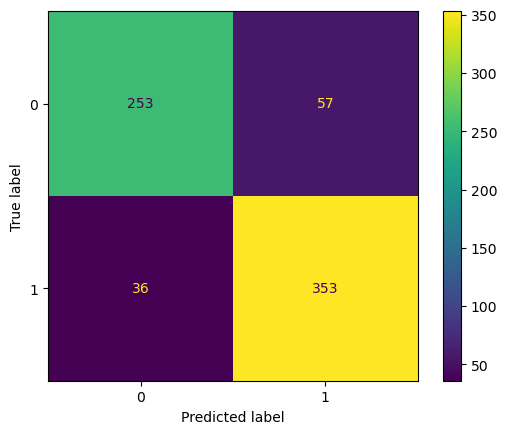

In [20]:
#Create a confusion matrix
#Create a confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred),
                             display_labels=gs.classes_)

disp.plot();

In [21]:
# How sensitive is this model?
metrics.recall_score(y_test, pred)

0.9074550128534704

In [22]:
# What is the specificity of the model?  - I care about this metric more, but unfortunately doesn't do as well here.
tn / (tn + fp)

0.8161290322580645

In [23]:
# Recall is the same as sensitivity 
metrics.recall_score(y_test, pred)

0.9074550128534704

In [24]:
# Precision score.  How many were correctly predicted to go in the fountainpens reddit?
metrics.precision_score(y_test, pred)

0.8609756097560975

<Figure size 2000x800 with 0 Axes>

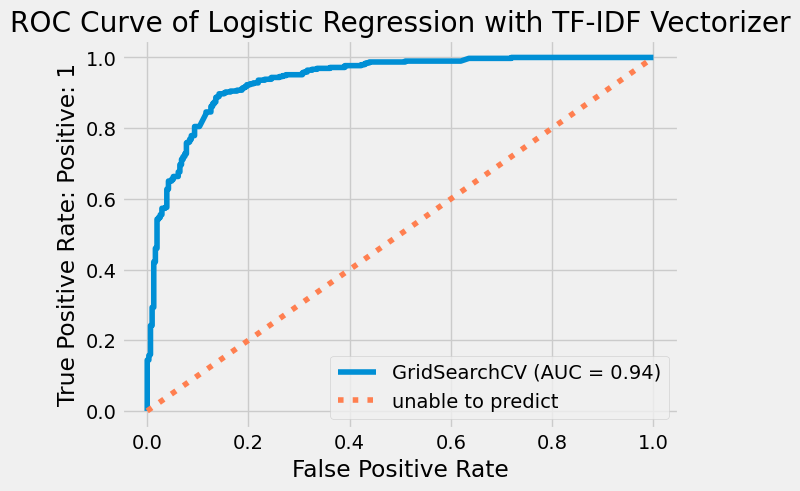

In [25]:
plt.figure(figsize = (20,8))
plt.style.use("fivethirtyeight")
plt.tight_layout()

RocCurveDisplay.from_estimator(gs, X_test, y_test)

# The 50/50 line
plt.plot([0,1], [0,1],
         label = 'unable to predict',
         linestyle = 'dotted',
         color = 'coral');

# Legend
plt.legend()
plt.title('ROC Curve of Logistic Regression with TF-IDF Vectorizer')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate: Positive: 1')
plt.savefig('./plot_images/logreg_cvec_roc_curve.png', dpi = 192);